In [65]:
import librosa  # for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # for audio processing
from numpy.lib.stride_tricks import as_strided
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import pandas as pd
from os.path import exists
import warnings
warnings.filterwarnings("ignore")


In [66]:
train_audio_path = '../data/train/wav/'
samples, sample_rate = librosa.load(train_audio_path+'tr_1_tr01001.wav')
print(samples)
print(sample_rate)

[-0.00502738 -0.00577551 -0.0046026  ... -0.00579655 -0.00516981
  0.        ]
22050


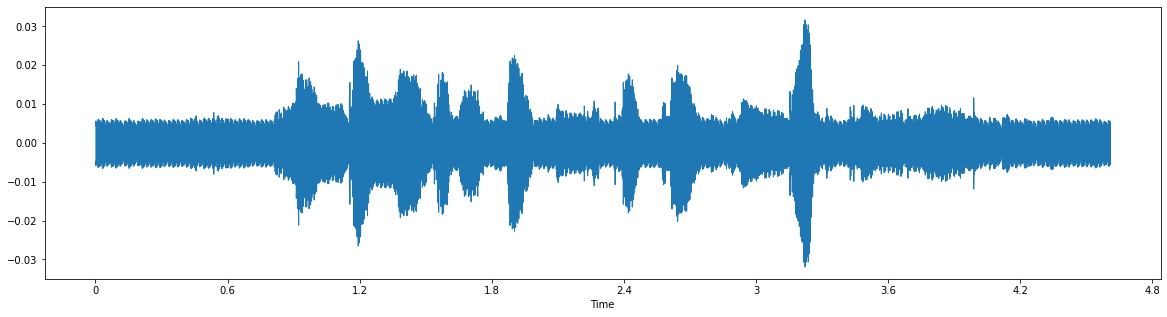

In [67]:
# Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.show()

In [68]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [69]:
spe_samples, frequency = spectrogram(samples)
print(frequency)
print(spe_samples)

[0.        0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375   0.1015625
 0.109375  0.1171875 0.125     0.1328125 0.140625  0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1875    0.1953125 0.203125  0.2109375
 0.21875   0.2265625 0.234375  0.2421875 0.25      0.2578125 0.265625
 0.2734375 0.28125   0.2890625 0.296875  0.3046875 0.3125    0.3203125
 0.328125  0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875  0.4296875
 0.4375    0.4453125 0.453125  0.4609375 0.46875   0.4765625 0.484375
 0.4921875 0.5       0.5078125 0.515625  0.5234375 0.53125   0.5390625
 0.546875  0.5546875 0.5625    0.5703125 0.578125  0.5859375 0.59375
 0.6015625 0.609375  0.6171875 0.625     0.6328125 0.640625  0.6484375
 0.65625   0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75      0.7578125
 0.765625  0.77343

In [70]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    # plt.savefig('spectogramfeature.png')

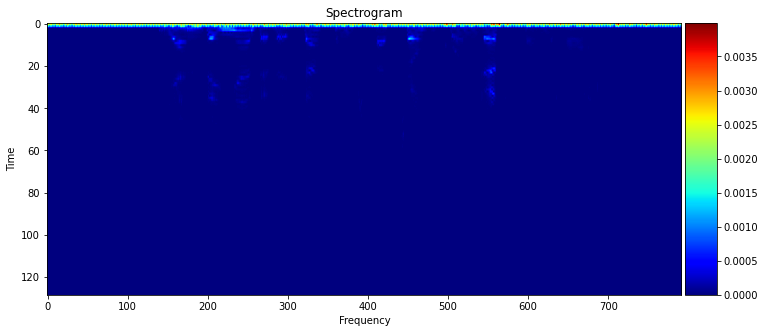

In [71]:
plot_spectrogram_feature(spe_samples)


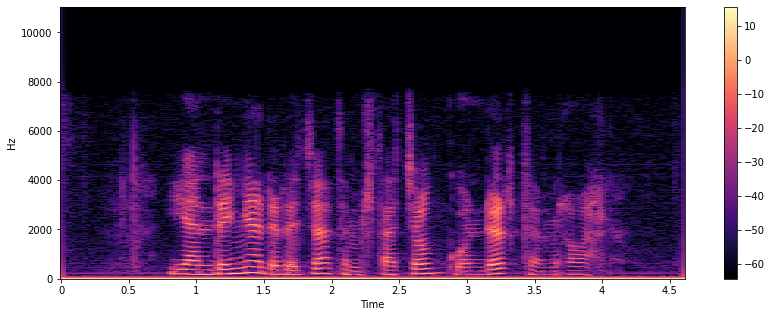

In [72]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()
# plt.savefig('specshow.png')

In [73]:
def plot_spec(data: np.array, sr: int) -> None:
    '''
    Function for plotting spectrogram along with amplitude wave graph
    '''

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
    ax[0].specgram(data, Fs=2)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0, 1, len(data)), data)
    # fig.savefig('spectogramamplitude.png')

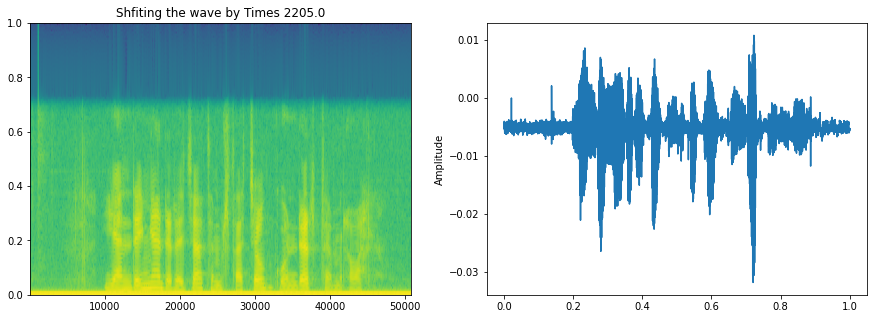

In [74]:
wav_roll = np.roll(samples, int(sample_rate/10))
plot_spec(data=wav_roll, sr=sample_rate)
# ipd.Audio(wav_roll,rate=sample_rate)

(20, 199)


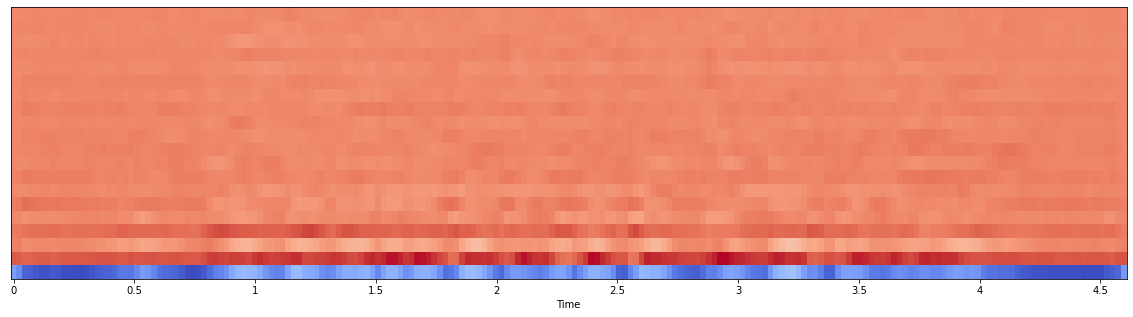

In [75]:
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(samples, sr=sample_rate)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
print(mfccs.shape)

In [76]:
def tran_loader(filename):
    name_to_text = {}
    with open(filename, encoding="utf-8")as f:
        f.readline()
        for line in f:
            name = line.split("</s>")[1]
            name = name.replace('(', '')
            name = name.replace(')', '')
            name = name.replace('\n', '')
            name = name.replace(' ', '')
            text = line.split("</s>")[0]
            text = text.replace("<s>", "")
            name_to_text[name] = text
        return name_to_text

In [77]:

transcription = tran_loader("../data/train/trsTrain.txt")

In [89]:
def meta_data(trans, path):
    target = []
    features = []
    mode=[]
    rmse=[]
    spec_cent=[]
    spec_bw=[]
    rolloff=[]
    zcr=[]
    mfcc=[]
    filenames = []
    duration_of_recordings = []
    for index, k in enumerate(trans):
        if index < 200:
            filename = path + k + ".wav"
            if exists(filename):
                filenames.append(filename)
                audio, fs = librosa.load(filename, sr=None)
                chroma_stft = librosa.feature.chroma_stft(y = audio, sr = fs)
                rmse.append(np.mean(librosa.feature.rms(y = audio)))
                spec_cent.append(np.mean(librosa.feature.spectral_centroid(y = audio, sr = fs))
                spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y = audio, sr = fs)))
                rolloff.append(np.mean(librosa.feature.spectral_rolloff(y = audio, sr = fs)))
                zcr.append(np.mean(librosa.feature.zero_crossing_rate(audio)))
                mfcc.append(np.mean(librosa.feature.mfcc(y = audio, sr = fs)))
    # to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} 
                duration_of_recordings.append(float(len(audio)/fs))
                mode.append('mono' if len(audio.shape) == 1 else 'stereo')
                lable = trans[k]
                target.append(lable)
    return filenames, target, duration_of_recordings,mode,rmse,spec_cent,spec_bw,rollfoo,zcr,mfcc

SyntaxError: invalid syntax (3403766716.py, line 22)

In [79]:
filenames, target, duration_of_recordings,mode ,rmse,spec_cent,spec_bw,rollfoo,zcr,mfcc = meta_data(transcription, '../data/train/wav/')
data = pd.DataFrame({'key': filenames, 'text': target,
                    'duration': duration_of_recordings, 'mode': mode ,'rmse': rmse,'spec_cent' :spec_cent,'spec_bw': spec_bw,"rollfoo" :rollfoo,"zcr": zcr,"mfcc": mfcc})
data.head()
# print(data.shape)

,key,text,duration,mode
0,../data/train/wav/tr_2_tr01002.wav,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...,16.384,mono
1,../data/train/wav/tr_3_tr01003.wav,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...,14.592,mono
2,../data/train/wav/tr_4_tr01004.wav,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,4.736,mono
3,../data/train/wav/tr_5_tr01005.wav,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...,8.192,mono
4,../data/train/wav/tr_6_tr01006.wav,ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያ...,8.704,mono


In [80]:
spectral_centroids = librosa.feature.spectral_centroid(
    samples, sr=sample_rate)[0]

spectral_centroids.shape

(199,)

In [81]:
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

<Figure size 864x288 with 0 Axes>

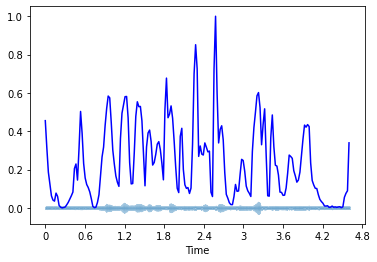

In [82]:
# Normalising the spectral centroid for visualisation


def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
plt.show()

[3951.34277344 3445.3125     1571.92382812  613.69628906  139.96582031
   96.89941406   96.89941406  172.265625     96.89941406   86.1328125
   86.1328125    86.1328125    86.1328125    86.1328125    96.89941406
  129.19921875  333.76464844  495.26367188 1055.12695312 2788.54980469
 2896.21582031 1905.68847656 3359.1796875  4209.74121094 3768.31054688
 2767.01660156 2088.72070312 1830.32226562 1604.22363281  990.52734375
  204.56542969   64.59960938   64.59960938   75.36621094  247.63183594
  452.19726562 2583.984375   3133.08105469 3165.38085938 3079.24804688
 3133.08105469 3348.41308594 3413.01269531 3143.84765625 2422.48535156
 2164.08691406 1981.0546875  1808.7890625  1270.45898438 3111.54785156
 3046.94824219 3046.94824219 3240.74707031 3294.58007812 3176.14746094
 2594.75097656 1238.15917969 1152.02636719 2616.28417969 3100.78125
 3154.61425781 3176.14746094 3154.61425781 2993.11523438 2433.25195312
 1582.69042969 2799.31640625 2820.84960938 2831.61621094 2713.18359375
 2379.4189

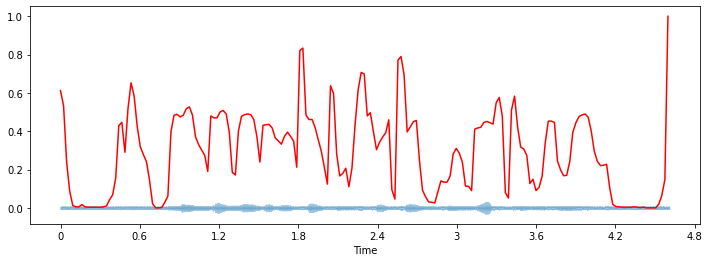

In [88]:
spectral_rolloff = librosa.feature.spectral_rolloff(
    samples+0.01, sr=sample_rate)[0]
# print(spectral_rolloff)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()


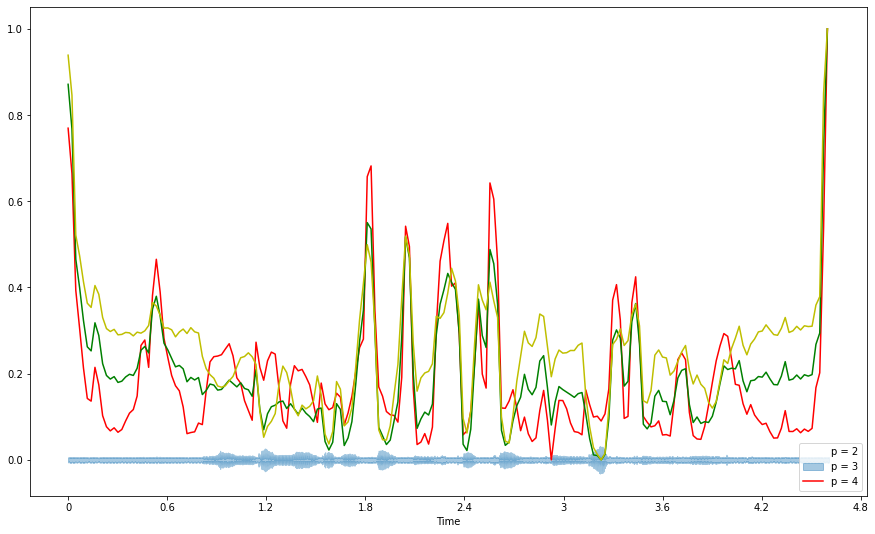

In [84]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate, p=4)[0]
plt.figure(figsize=(15, 9))

librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.show()

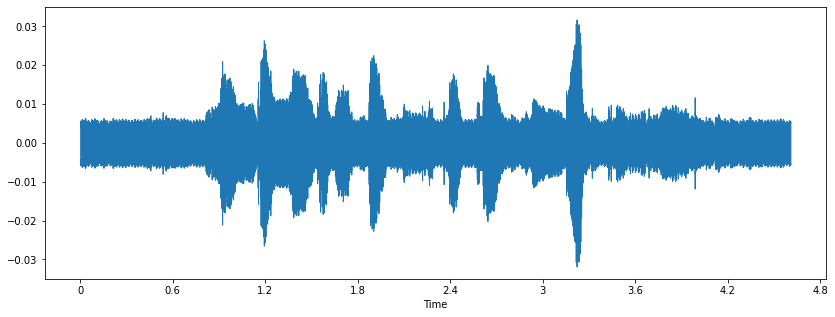

In [85]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(samples, sr=sample_rate)


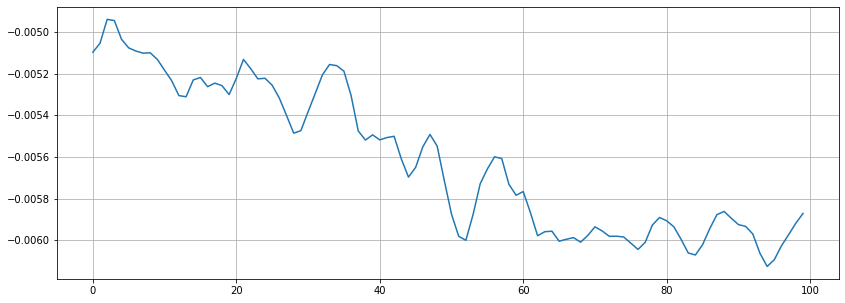

In [86]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(samples[n0:n1])
plt.grid()
plt.show()

In [87]:
data.to_csv('../data/train_data.csv')